In [1]:
import os, h5py
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch 
import copy
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

seed = 12387
torch.manual_seed(seed)
if cuda: 
    torch.cuda.manual_seed(seed)

## 1. load $\theta$ and $m(\theta)$

In [5]:
dat_dir = '/scratch/gpfs/chhahn/21cmlfi/'
f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'r')

thetas = f['theta'][...]
del2_nonoise = f['Del2_21_nonoise'][...]

f.close()

## 2. noise model 
$$\Delta^2_{21}(\theta', \sigma, s) = m(\theta') + \epsilon'_{\rm thermal} + \epsilon'_{\rm systematics}$$
where $\epsilon'_{\rm thermal} = \mathcal{N}(0, \sigma)$ and $\epsilon'_{\rm systematics} = \mathcal{U}(0, s)$

In [6]:
def apply_noise(model, sigma, systematics): 
    ''' apply noise model t
    '''
    eps_t = sigma * np.random.normal(size=model.shape)
    eps_s = systematics * np.random.uniform(size=model.shape)
    
    return model + eps_t + eps_s

## 3. Forecast 


### 3.1 Generate noisy $\Delta^2_{21}$
$$\Delta^2_{21}(k=0.17, z=10.4) = 1700, \Delta_{21}^2(k=0.13, z=7.9) = 200$$
$$\sigma_{z = 10.4} = 3600, \sigma_{z = 7.9} = 300$$
$$s_{z = 10.4} = 1700, s_{z = 7.9} = 200$$

In [7]:
del2_obs = np.array([1700.,  200.])
del2_noise = apply_noise(del2_nonoise, np.array([3600., 300.]), del2_obs)

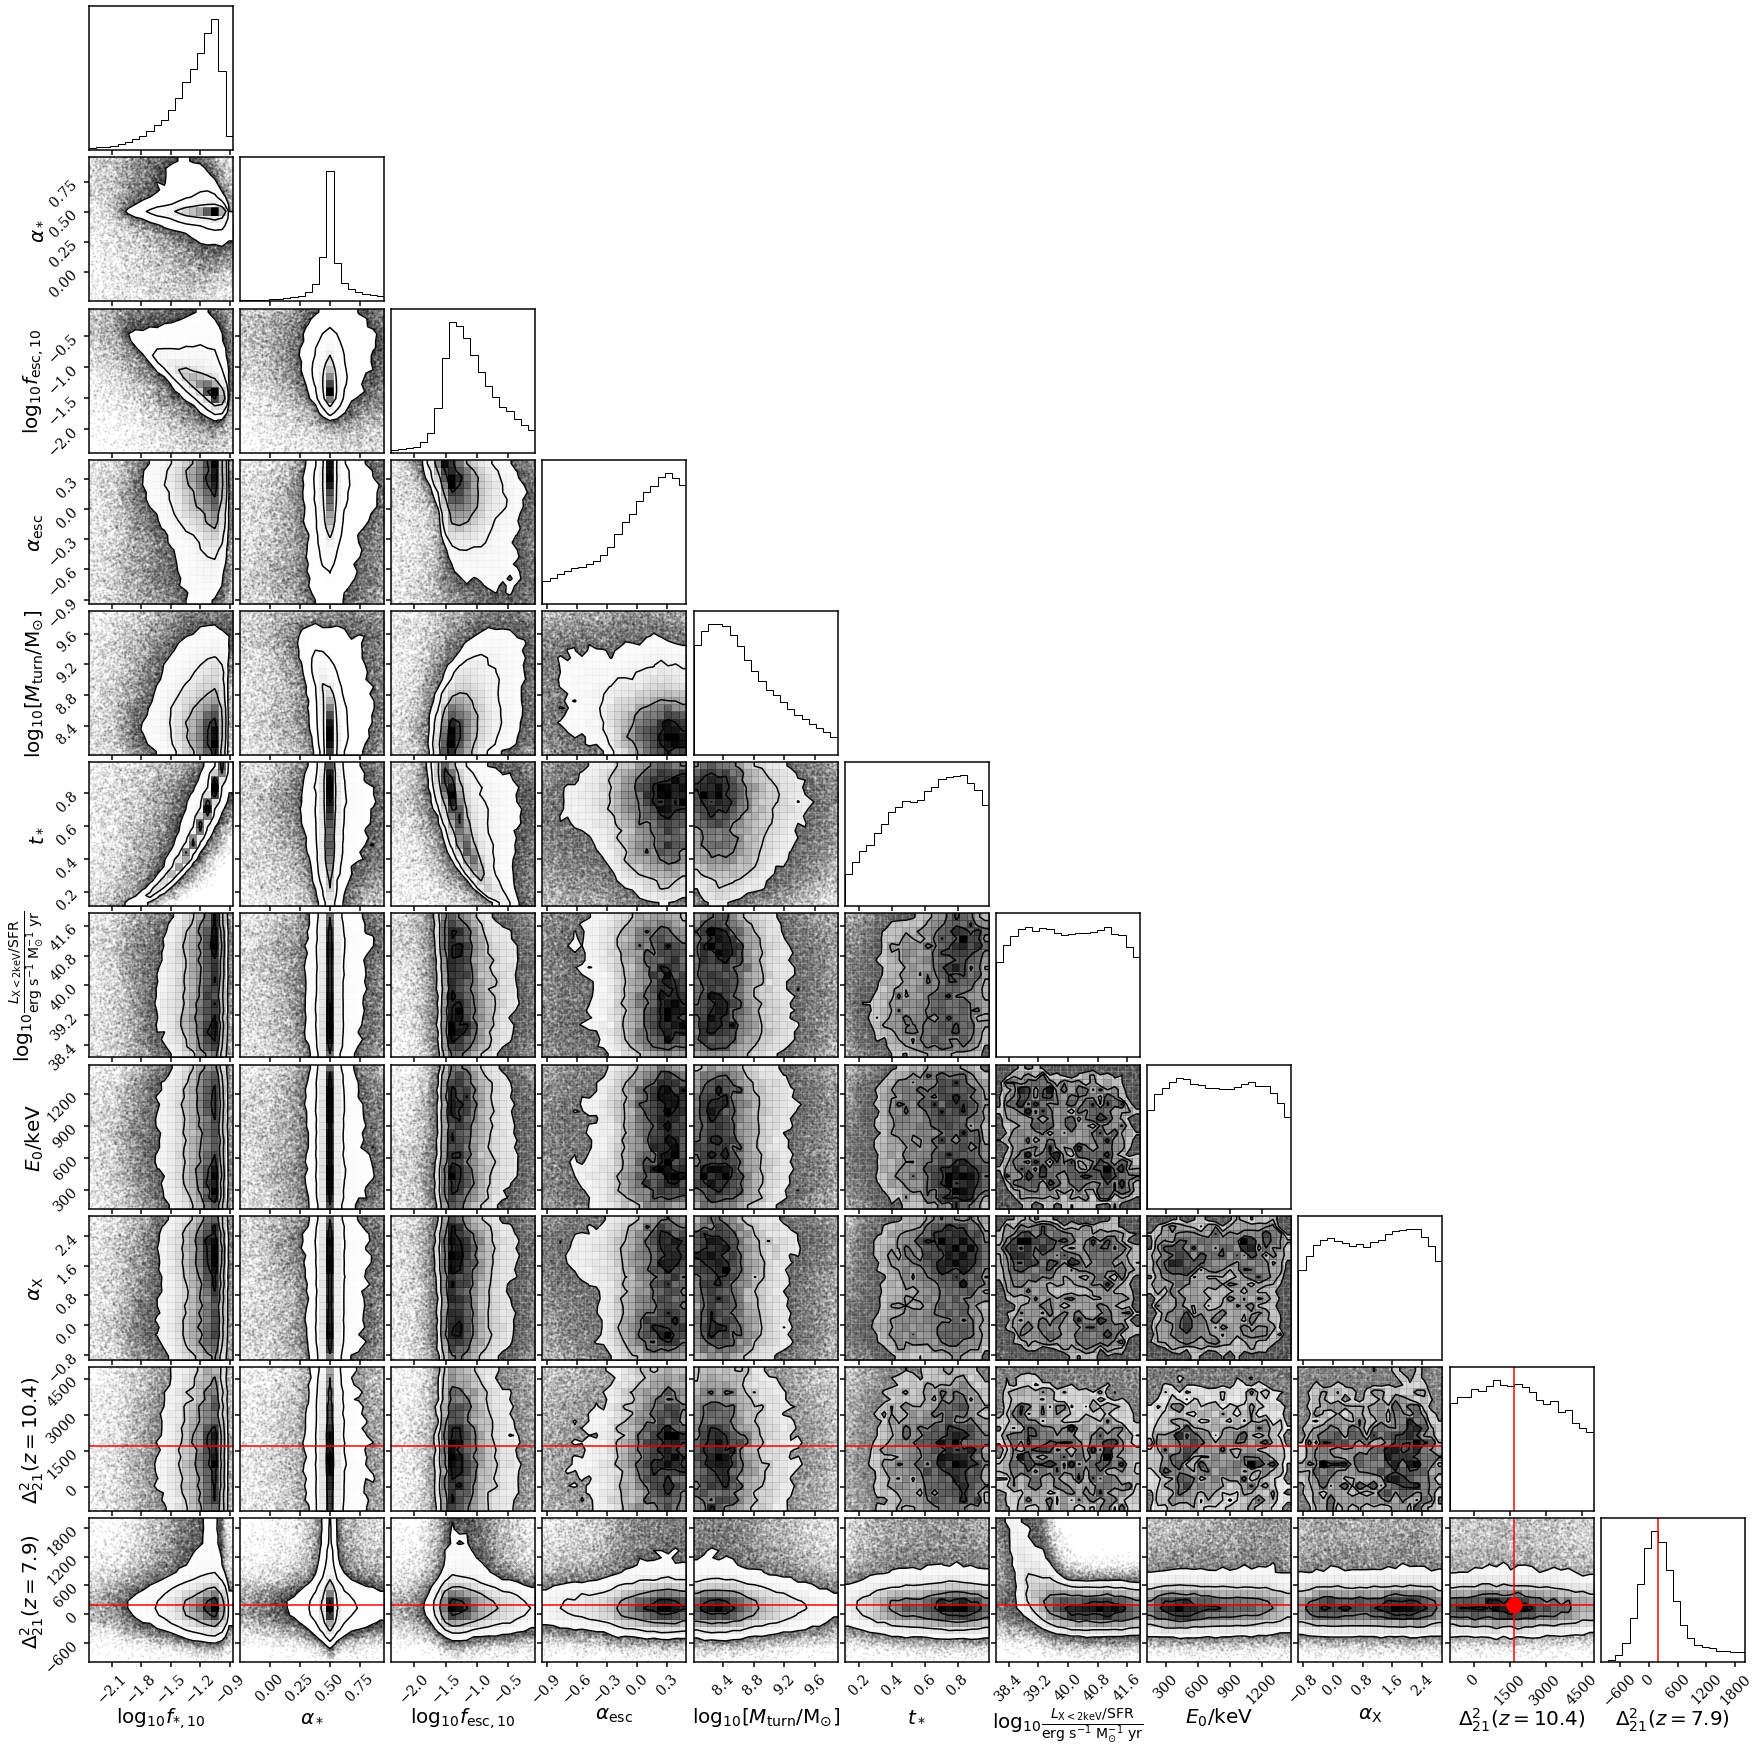

In [8]:
lbl_params = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])

prior_params = [[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]]

fig = DFM.corner(np.concatenate([thetas, del2_noise], axis=1), 
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params) + [r'$\Delta_{21}^2(z=10.4)$', r'$\Delta_{21}^2(z=7.9)$'],
                 label_kwargs={'fontsize': 20})
DFM.overplot_points(fig, [[None for _ in lbl_params] + list(del2_obs)], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + list(del2_obs), color='r')

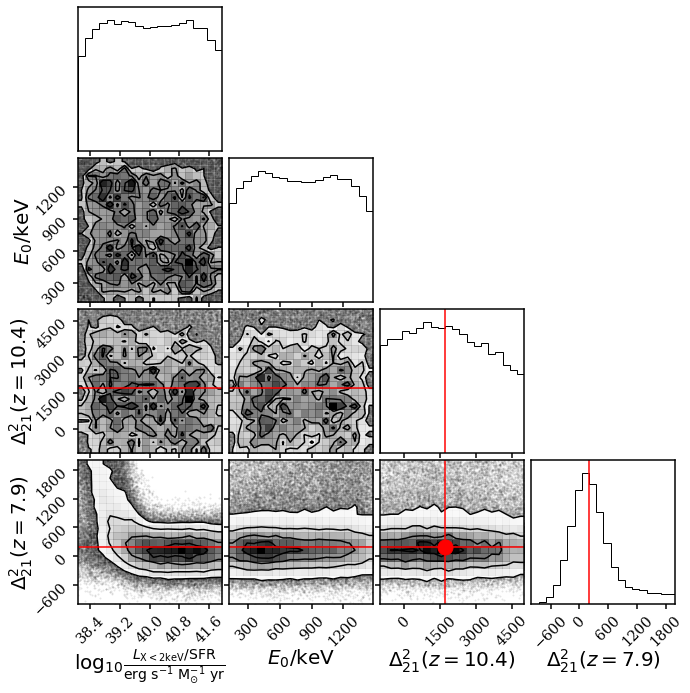

In [9]:
fig = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), 
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=10.4)$', r'$\Delta_{21}^2(z=7.9)$'],
                 label_kwargs={'fontsize': 20})
DFM.overplot_points(fig, [[None, None] + list(del2_obs)], color='r', markersize=30)
DFM.overplot_lines(fig, [None, None] + list(del2_obs), color='r')

### 3.2. Train NPE

In [10]:
# set priors 
prior_params = [[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]]
lower_bounds = torch.tensor([_p[0] for _p in prior_params])
upper_bounds = torch.tensor([_p[1] for _p in prior_params])

lower_bounds[-2] = 100.
upper_bounds[-2] = 1500.0

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device=("cuda" if cuda else "cpu"))

In [11]:
def train_npe(thetas, obs, n_models=3): 
    '''
    '''
    phats, best_valid_logprobs = [], []
    for i in range(n_models):
        nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(128)))))
        nblocks = int(np.random.uniform(3, 10))
        print('MAF with nhidden=%i; nblocks=%i' % (nhidden, nblocks))
        arch = '%ix%i' % (nhidden, nblocks)

        anpe = Inference.SNPE(prior=prior,
                              density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
                              device=("cuda" if cuda else "cpu"))
        anpe.append_simulations(
            torch.as_tensor(thetas.astype(np.float32)),
            torch.as_tensor(obs.astype(np.float32)))

        _phat = anpe.train(training_batch_size=256)

        p_theta_obs_est = anpe.build_posterior(_phat)
        
        phats.append(p_theta_obs_est)
        best_valid_logprobs.append(anpe._summary['best_validation_log_probs'])

    ibest = np.argmax(best_valid_logprobs)
    return copy.deepcopy(phats[ibest])

In [13]:
phat = train_npe(thetas, del2_noise, n_models=1)

MAF with nhidden=101; nblocks=5
Neural network successfully converged after 116 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

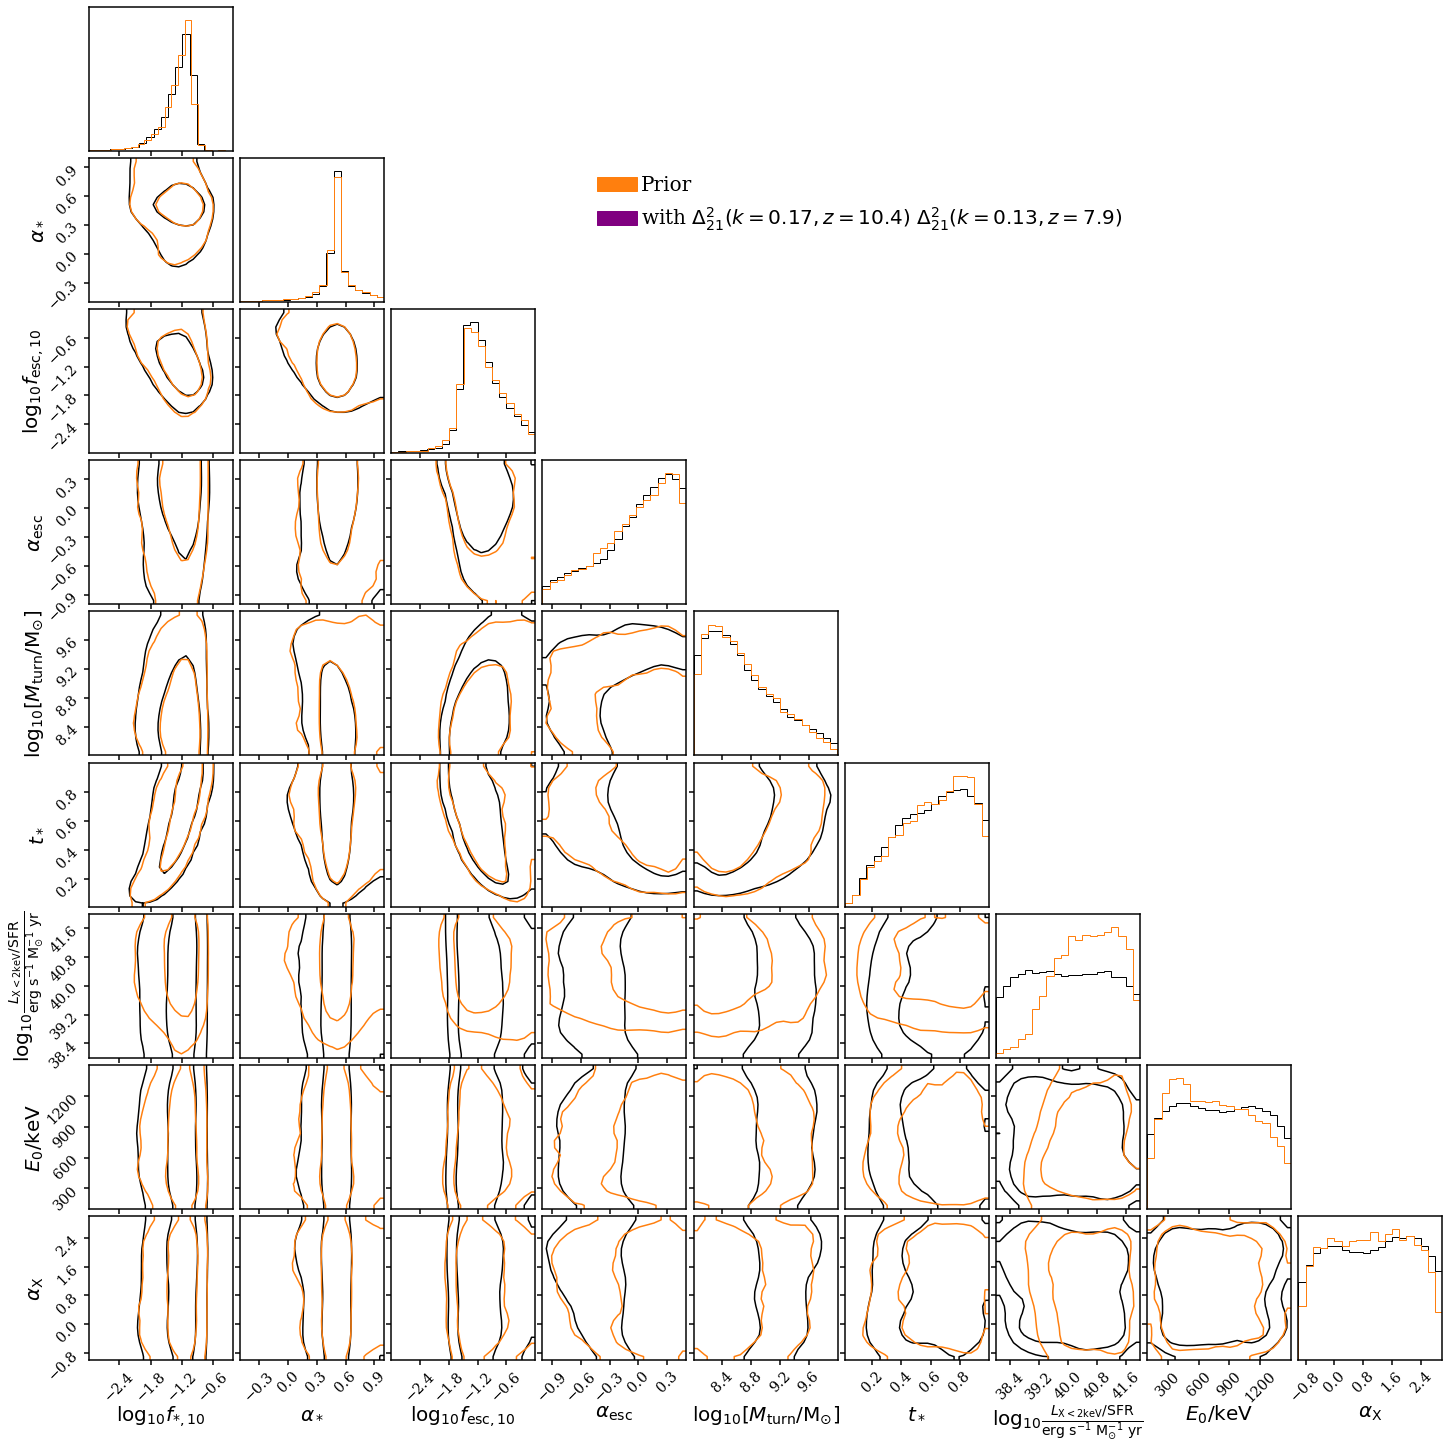

In [18]:
mcmc_npe = phat.sample((10000,),
                        x=torch.as_tensor(del2_obs.astype(np.float32)).to(device), 
                        show_progress_bars=True)

fig = DFM.corner(thetas, 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)
_ = DFM.corner(np.array(mcmc_npe.detach().to('cpu')), color='C1', 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 9
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-3]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C1', label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$ $\Delta_{21}^2(k=0.13, z=7.9)$')
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

## 4. scale down measurements and noise

In [12]:
del2_noises, mcmc_npes = [], [] 
for i in [2, 5, 10]: 
    del2_obs = np.array([1700.,  200.]) / float(i)
    del2_noise = apply_noise(del2_nonoise, np.array([3600., 300.]) / float(i), del2_obs)
    del2_noises.append(del2_noise)
    
    phat = train_npe(thetas, del2_noise, n_models=1)
    
    mcmc_npe = phat.sample((10000,),
                        x=torch.as_tensor(del2_obs.astype(np.float32)).to(device), 
                        show_progress_bars=True)
    
    mcmc_npes.append(np.array(mcmc_npe.detach().to('cpu')))

MAF with nhidden=95; nblocks=3
Neural network successfully converged after 142 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

MAF with nhidden=112; nblocks=9
Neural network successfully converged after 110 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

MAF with nhidden=92; nblocks=9
Neural network successfully converged after 132 epochs.


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

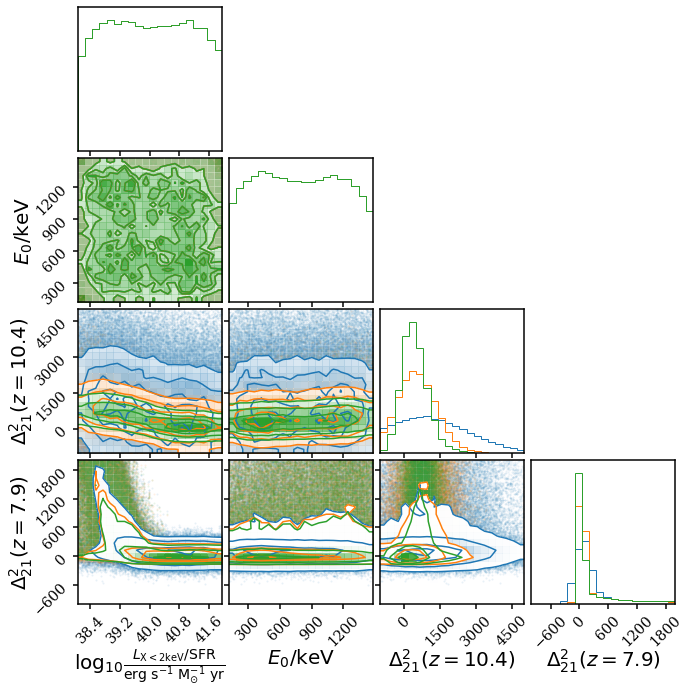

In [17]:
for i, del2_noise in enumerate(del2_noises):
    if i == 0:     
        fig = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), color='C%i' % i,
                         range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)],  
                         labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=10.4)$', r'$\Delta_{21}^2(z=7.9)$'],
                         label_kwargs={'fontsize': 20})
    else: 
        _ = DFM.corner(np.concatenate([thetas[:,6:8], del2_noise], axis=1), color='C%i' % i,
                         range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)],  
                         labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2(z=10.4)$', r'$\Delta_{21}^2(z=7.9)$'],
                         label_kwargs={'fontsize': 20}, fig=fig)
plt.show()

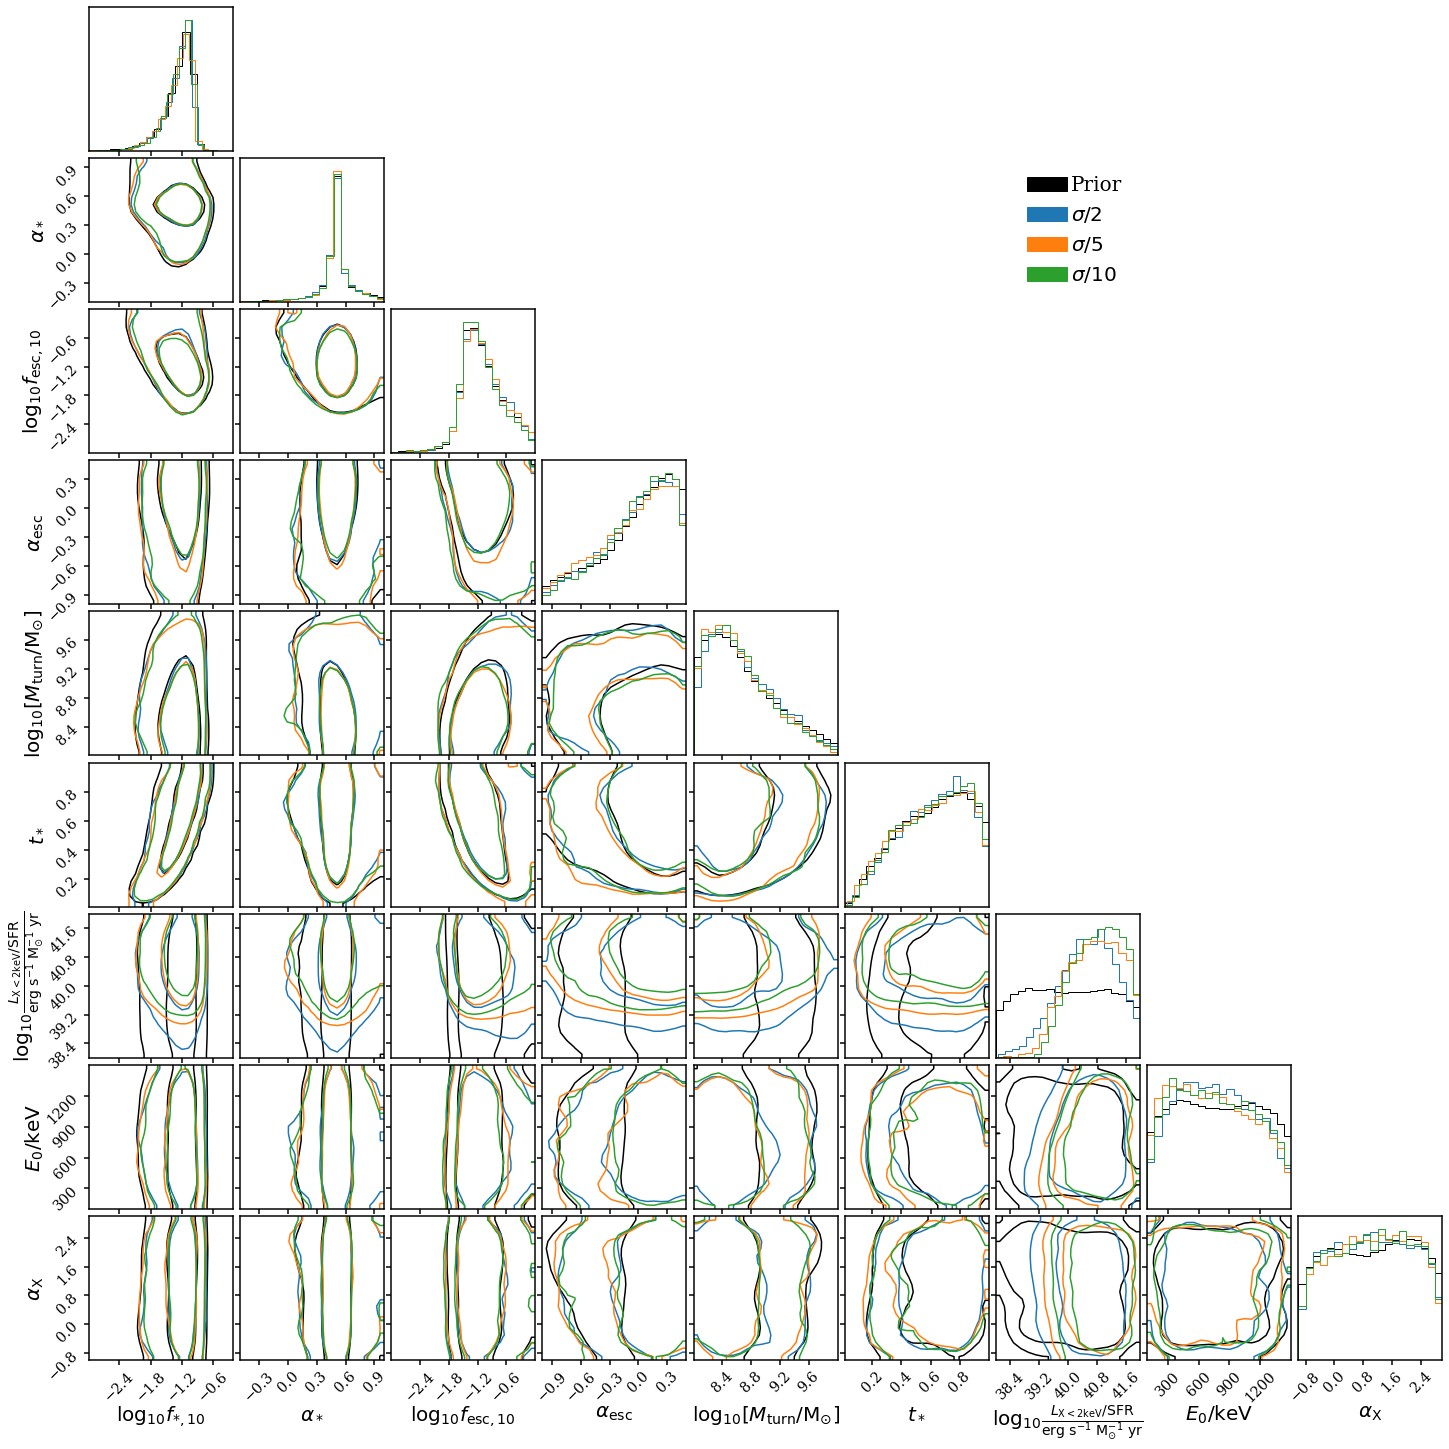

In [21]:
fig = DFM.corner(thetas, 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)

for i, mcmc_npe in enumerate(mcmc_npes): 
    _ = DFM.corner(mcmc_npe, color='C%i' % i, 
                   levels=[0.68, 0.95], 
                   labels=lbl_params,
                   label_kwargs={'fontsize': 20},
                   hist_kwargs={'density': True},
                   smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 9
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-3]
ax.fill_between([], [], [], color='k', label='Prior')
for ii, i in enumerate([2, 5, 10]): 
    ax.fill_between([], [], [], color='C%i' % ii, label=r'$\sigma/%i$' % i) 
    # label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$ $\Delta_{21}^2(k=0.13, z=7.9)$')
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

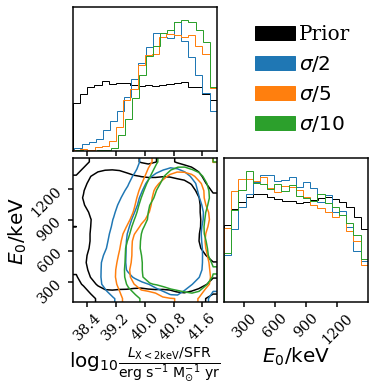

In [27]:
fig = DFM.corner(thetas[:,6:8], 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params[6:8],
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)

for i, mcmc_npe in enumerate(mcmc_npes): 
    _ = DFM.corner(mcmc_npe[:,6:8], color='C%i' % i, 
                   levels=[0.68, 0.95], 
                   labels=lbl_params[6:8],
                   label_kwargs={'fontsize': 20},
                   hist_kwargs={'density': True},
                   smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[0,1]
ax.fill_between([], [], [], color='k', label='Prior')
for ii, i in enumerate([2, 5, 10]): 
    ax.fill_between([], [], [], color='C%i' % ii, label=r'$\sigma/%i$' % i) 
    # label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$ $\Delta_{21}^2(k=0.13, z=7.9)$')
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)